In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
idx = pd.IndexSlice
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

In [3]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
plt.rcParams['legend.loc'] = "upper right"

In [4]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [5]:
%%sql
INSTALL sqlite;
LOAD sqlite;

,Success


In [6]:
%%sql
ATTACH './databases/404271.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

,Success


In [7]:
nodes = %sql SELECT * FROM expdb.Node
nodes

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [8]:
database = %sql select * from duckdb_databases()  where duckdb_databases.path like '%.db'
database

,database_name,database_oid,path,comment,tags,internal,type,readonly
0,expdb,1776,./databases/404271.db,None,"{'key': [], 'value': []}",False,sqlite,False


In [9]:
nodes_with_queries = %sql SELECT node_id, count(*) FROM expdb.Trace WHERE Trace.message like 'Execute Queries%' GROUP BY Trace.node_id;
nodes_with_queries


,node_id,count_star()
0,70B3D57ED005EA60,28
1,70B3D57ED005EA64,25
2,70B3D57ED005EA65,25
3,70B3D57ED005EA61,27
4,70B3D57ED005EA59,28
5,70B3D57ED005EA66,24
6,70B3D57ED005EA62,27
7,70B3D57ED005EA63,26
8,70B3D57ED005EA67,24
9,70B3D57ED005EA68,24


In [10]:
power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption

#reduce memory consumption
power_consumption[["power", "current", "voltage"]] = power_consumption[["power", "current", "voltage"]].apply(pd.to_numeric, downcast="float")
power_consumption["node_id"] = power_consumption["node_id"].astype("category")
power_consumption.head()
#filter to only contain results where we have a query
power_consumption = power_consumption[power_consumption["node_id"].isin(nodes_with_queries["node_id"])]
#power_consumption = power_consumption.set_index(["node_id","timestamp"])
#power_consumption = power_consumption.sort_index()

In [11]:
power_consumption.memory_usage(deep=True)

Index              128
timestamp    283270136
power        141635068
current      141635068
voltage      141635068
node_id       35409870
dtype: int64

In [12]:
import json
from pathlib import Path
EXP_ID = Path(database.loc[0, "path"]).stem
##find config file

EXP_CONFIG = json.load(open(next((Path.cwd() / "data" / str(EXP_ID)).glob("*.json"))))

In [13]:
print(f"""
EXPERIMENT OVERVIEW:

expid: {EXP_ID}
duration: {EXP_CONFIG["DURATION"]} minutes
epoch: {EXP_CONFIG["EXECUTION_EPOCH_S"]} seconds
sites used: {" ".join(nodes["node_site"].unique())}

Node overview:
{nodes.groupby(["node_site","riot_board"]).size().to_string()}
""")


EXPERIMENT OVERVIEW:

expid: 404271
duration: 60 minutes
epoch: 120 seconds
sites used: saclay

Node overview:
node_site  riot_board    
saclay     b-l072z-lrwan1    11



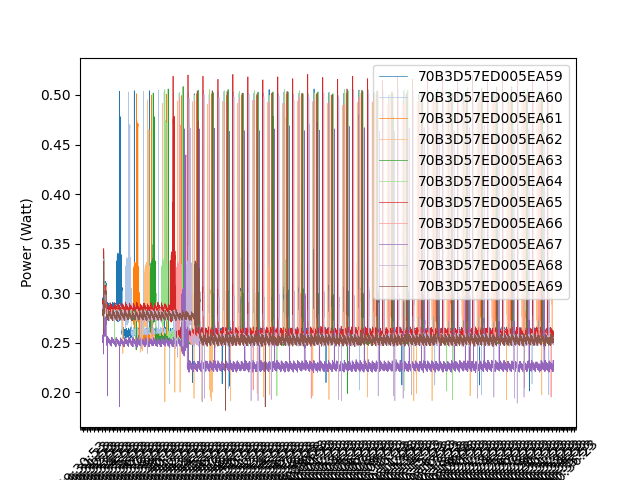

In [14]:
plt.figure()

for node_id, group in power_consumption.groupby("node_id", observed=True):
    idxs = np.linspace(0,len(group), 50000, endpoint=False, dtype=int)
    
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    plt.plot(subset_timestamp, subset_power, label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

## finding sync signals

In [15]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

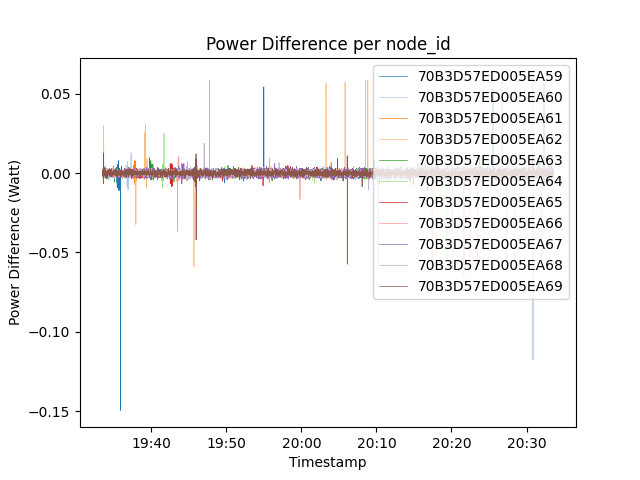

In [16]:
#diff of each group
power_consumption['power_diff'] = power_consumption.groupby("node_id", observed=True)["power"].diff()


plt.figure()
for node_id, group in power_consumption.groupby("node_id", observed=True):
    idxs = np.linspace(0,len(group), 5000, endpoint=False, dtype=int) # there are comparatively few but big jumps, so hard to see when just taking "random" indexes
    subset_power_diff = group["power_diff"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    plt.plot(subset_timestamp, subset_power_diff, label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

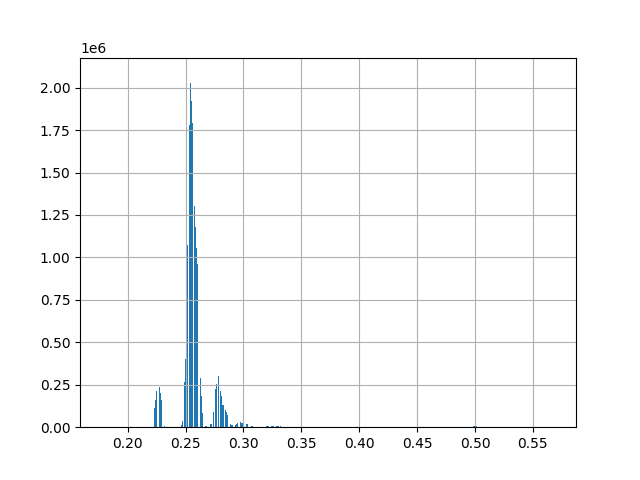

In [17]:
plt.figure()
power_consumption['power'].hist(bins=1000)
plt.show()

In [18]:
EDGE_SIZE = 0.07
rising_edge = power_consumption[power_consumption["power_diff"] > EDGE_SIZE].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -EDGE_SIZE].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction
183645,2024-08-14 19:36:57.612229,0.361399,0.074258,4.86500,70B3D57ED005EA60,0.073256,rising
183660,2024-08-14 19:36:57.629164,0.302183,0.062073,4.87000,70B3D57ED005EA60,-0.082414,falling
183799,2024-08-14 19:36:57.786098,0.484104,0.099360,4.86875,70B3D57ED005EA60,0.202066,rising
183976,2024-08-14 19:36:57.985995,0.391312,0.080387,4.86750,70B3D57ED005EA60,-0.108054,falling
183977,2024-08-14 19:36:57.987124,0.278985,0.057287,4.87375,70B3D57ED005EA60,-0.112327,falling


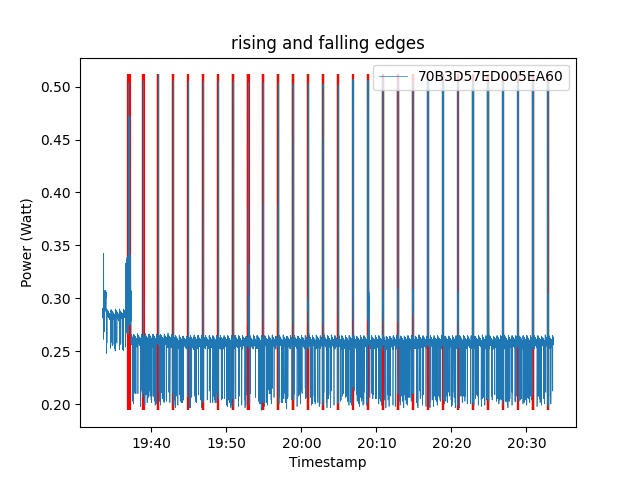

In [19]:
# plot the edges in an example
node_id = power_consumption["node_id"].iloc[0]
to_plot = power_consumption[power_consumption["node_id"] == node_id]
low_point = to_plot["power"].min()
high_point = to_plot["power"].max()
plt.figure()
plt.vlines(rising_edge[rising_edge["node_id"] == node_id]["timestamp"], ymin=low_point, ymax=high_point, color='green')
plt.vlines(falling_edge.loc[falling_edge["node_id"] == node_id, "timestamp"], ymin=low_point, ymax=high_point, color='red')
plt.plot(to_plot["timestamp"], to_plot["power"], label=node_id, linewidth=0.5)

plt.title("rising and falling edges")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

In [20]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation

edges['next_direction'] = edges.groupby('node_id', observed=True)['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id', observed=True)['timestamp'].shift(-1)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
183645,2024-08-14 19:36:57.612229,0.361399,0.074258,4.86500,70B3D57ED005EA60,0.073256,rising,falling,2024-08-14 19:36:57.629164
183660,2024-08-14 19:36:57.629164,0.302183,0.062073,4.87000,70B3D57ED005EA60,-0.082414,falling,rising,2024-08-14 19:36:57.786098
183799,2024-08-14 19:36:57.786098,0.484104,0.099360,4.86875,70B3D57ED005EA60,0.202066,rising,falling,2024-08-14 19:36:57.985995
183976,2024-08-14 19:36:57.985995,0.391312,0.080387,4.86750,70B3D57ED005EA60,-0.108054,falling,falling,2024-08-14 19:36:57.987124
183977,2024-08-14 19:36:57.987124,0.278985,0.057287,4.87375,70B3D57ED005EA60,-0.112327,falling,rising,2024-08-14 19:36:58.189249


In [21]:
# filter out edges that are too close to each other or too far apart. We add 5% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges["timestamp"] < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/40)))  & (edges['next_timestamp'] - edges["timestamp"] > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/40))))]

# filter out edges where the consumption between them is not relatively constant
#edges[['node_id','timestamp', 'next_timestamp']].apply(lambda x: power_consumption[(power_consumption['node_id'] == x['node_id']) & (power_consumption['timestamp'] >= x['timestamp']) & (power_consumption['timestamp'] <= x['next_timestamp'])]["power"].diff().mean() < 0.1, axis=1)

edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
183799,2024-08-14 19:36:57.786098,0.484104,0.099360,4.86875,70B3D57ED005EA60,0.202066,rising,falling,2024-08-14 19:36:57.985995
184156,2024-08-14 19:36:58.189249,0.487156,0.100020,4.87125,70B3D57ED005EA60,0.205729,rising,falling,2024-08-14 19:36:58.389116
289578,2024-08-14 19:38:57.232367,0.455412,0.093573,4.86750,70B3D57ED005EA60,0.173374,rising,falling,2024-08-14 19:38:57.432234
289935,2024-08-14 19:38:57.635488,0.458464,0.094135,4.87000,70B3D57ED005EA60,0.176426,rising,falling,2024-08-14 19:38:57.835355
395592,2024-08-14 19:40:56.944749,0.511575,0.104977,4.86875,70B3D57ED005EA60,0.224653,rising,falling,2024-08-14 19:40:57.144616


In [22]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges["timestamp"] - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,timestamp,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_start,sync_end
183799,2024-08-14 19:36:57.786098,0.484104,0.099360,4.86875,70B3D57ED005EA60,0.202066,rising,falling,2024-08-14 19:36:57.985995,2024-08-14 19:36:57.686098,2024-08-14 19:36:58.085995
184156,2024-08-14 19:36:58.189249,0.487156,0.100020,4.87125,70B3D57ED005EA60,0.205729,rising,falling,2024-08-14 19:36:58.389116,2024-08-14 19:36:58.089249,2024-08-14 19:36:58.489116
289578,2024-08-14 19:38:57.232367,0.455412,0.093573,4.86750,70B3D57ED005EA60,0.173374,rising,falling,2024-08-14 19:38:57.432234,2024-08-14 19:38:57.132367,2024-08-14 19:38:57.532234
289935,2024-08-14 19:38:57.635488,0.458464,0.094135,4.87000,70B3D57ED005EA60,0.176426,rising,falling,2024-08-14 19:38:57.835355,2024-08-14 19:38:57.535488,2024-08-14 19:38:57.935355
395592,2024-08-14 19:40:56.944749,0.511575,0.104977,4.86875,70B3D57ED005EA60,0.224653,rising,falling,2024-08-14 19:40:57.144616,2024-08-14 19:40:56.844749,2024-08-14 19:40:57.244616


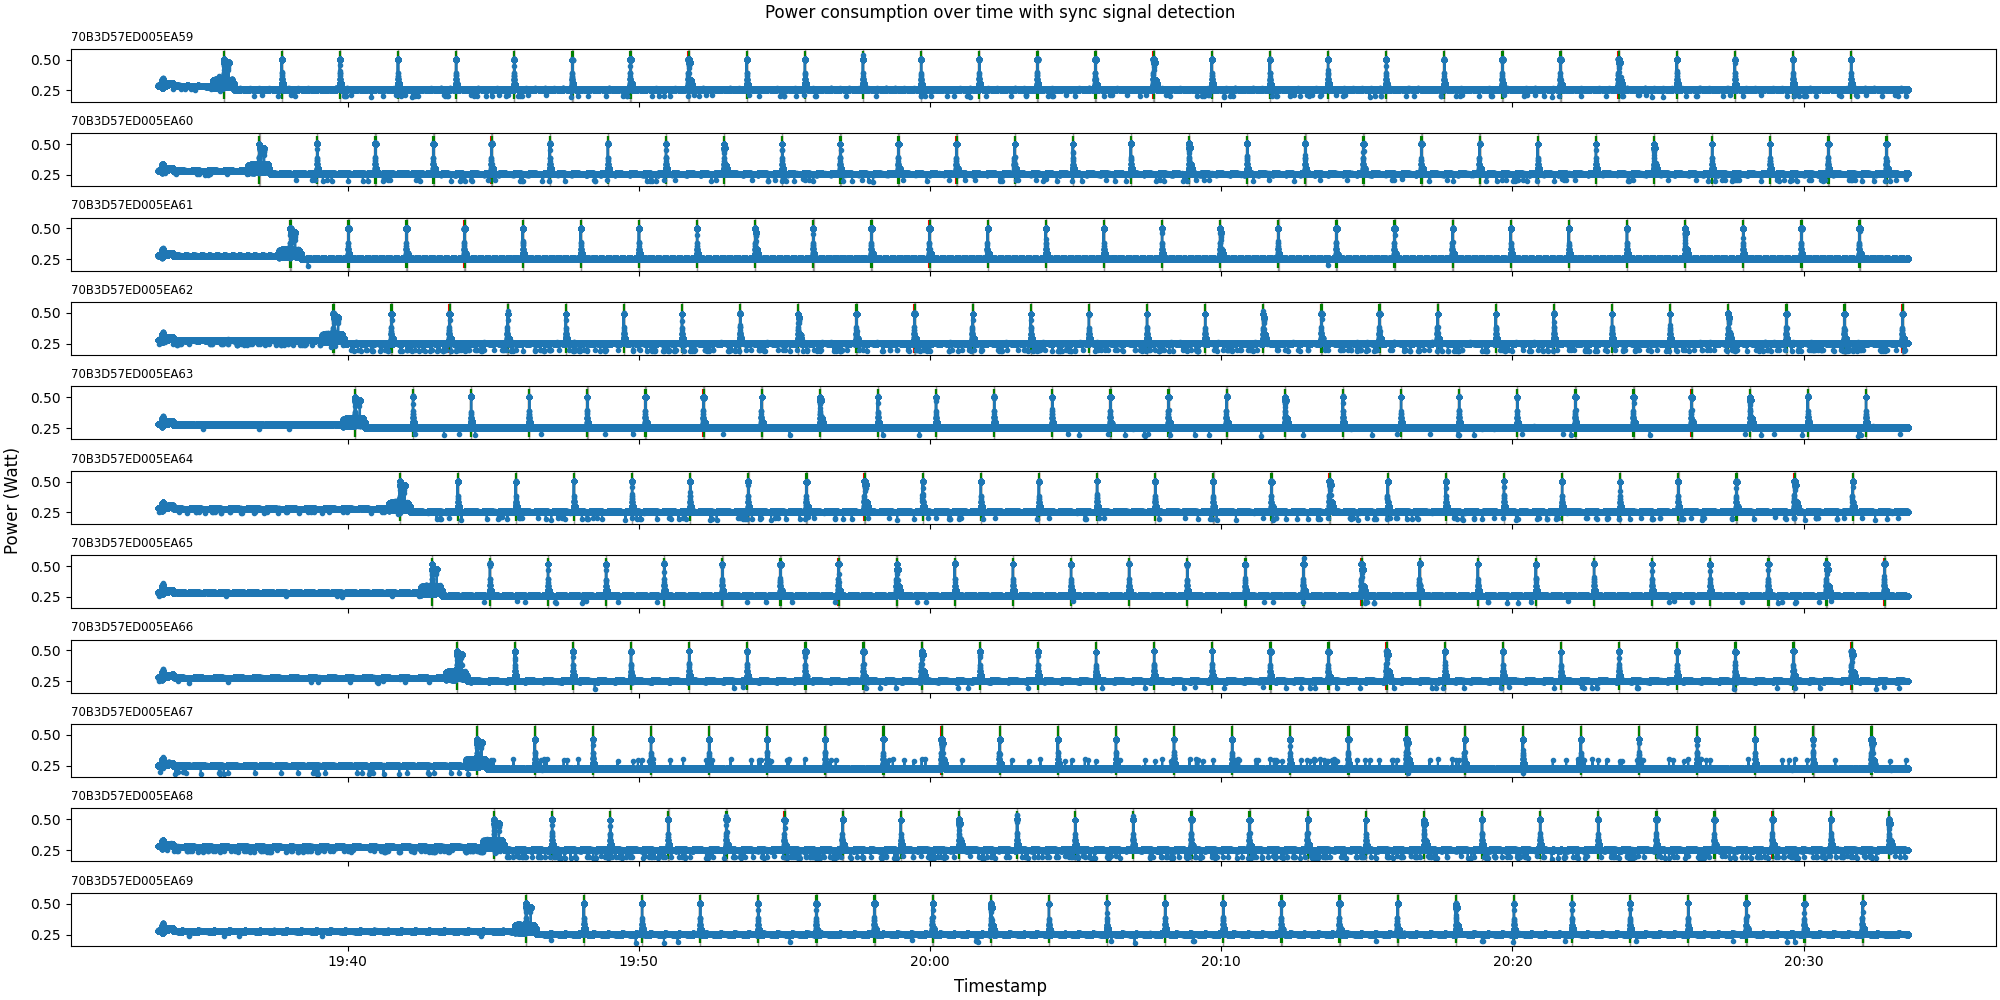

In [23]:
groups_by_node_id = power_consumption.groupby('node_id', observed=True)
edges_by_node_id = edges.groupby('node_id', observed=True)

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained', figsize=(20, 10))
## axs is not a list if there is only a single group, so we need to wrap it in a list
if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
    axs = [axs]

low_point = power_consumption["power"].min()
high_point = power_consumption["power"].max()

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with sync signal detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)

        ax.vlines(edges_grouped['timestamp'], ymin=low_point, ymax=high_point, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=low_point, ymax=high_point, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    idxs = np.linspace(0, len(group), endpoint=False, num=1000000, dtype=int)
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    ax.plot(subset_timestamp, subset_power, label=node_id, marker='.')
    ax.set_title(node_id, fontsize='small', loc='left')
plt.show()

In [24]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id', observed=True)
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[((edges['next_sync_start'] - edges['sync_end']) < pd.Timedelta(milliseconds=500)) & ((edges['next_sync_start'] - edges['sync_end']) > pd.Timedelta(milliseconds=0))][['node_id', 'sync_start', 'next_sync_end']].copy()
print(loops.columns)
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)

#filter out loops where the sync signals are too close to each other given the known duration of loops
#loops = loops[loops.groupby('node_id')["loop_signal_start"].diff() > pd.Timedelta(seconds=EXP_CONFIG["EXECUTION_EPOCH_S"]*0.5)]

loops['loop_num'] = loops.groupby('node_id', observed=True).cumcount()


## find any loops where the duration is higher than the expected duration. This should either be empty or only contain loop 0 loops
loops[loops.groupby('node_id', observed=True)["loop_signal_start"].diff() > pd.Timedelta(seconds=EXP_CONFIG["EXECUTION_EPOCH_S"]*1.5)]


Index(['node_id', 'sync_start', 'next_sync_end'], dtype='object')


,node_id,loop_signal_start,loop_signal_end,loop_num


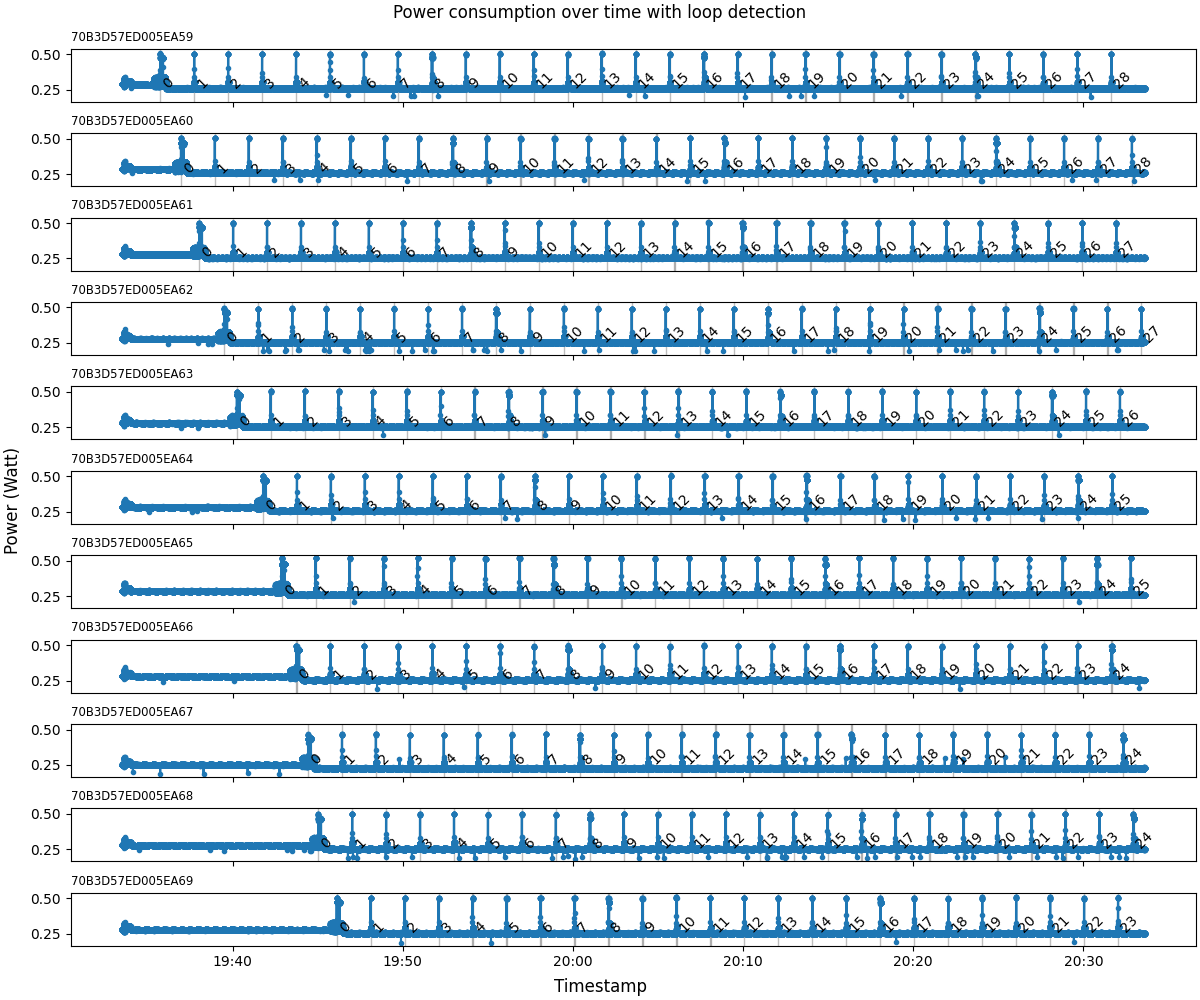

In [25]:

groups_by_node_id = power_consumption.groupby('node_id', observed=True)
loops_by_node_id = loops.groupby('node_id', observed=True)
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, figsize=(12, 10), layout='constrained')
text_y_pos = power_consumption['power'].mean()
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with loop detection")
## axs is not a list if there is only a single group, so we need to wrap it in a list'
if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
    axs = [axs]
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, text_y_pos, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    idxs = np.linspace(0, len(group), endpoint=False, num=100000, dtype=int)
    subset_power = group["power"].iloc[idxs]
    subset_timestamp = group["timestamp"].iloc[idxs]
    ax.plot(subset_timestamp, subset_power,label=node_id, marker='.')
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [26]:
%%sql timings << SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*deserialize: (-?[0-9]+)',1) as deserialize_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec tflite: (-?[0-9]+)',1) as exec_tflite_time_ms,
    regexp_extract(message, '.*Exec query: (-?[0-9]+)',1) as exec_query_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'

In [27]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
timings['node_id'].unique()

array(['70B3D57ED005EA59', '70B3D57ED005EA60', '70B3D57ED005EA61',
       '70B3D57ED005EA62', '70B3D57ED005EA63', '70B3D57ED005EA64',
       '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA67',
       '70B3D57ED005EA68', '70B3D57ED005EA69'], dtype=object)

In [28]:
# since duckdb return all columns as object we need to change types before we can merge

timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_tflite_time_ms', 'exec_query_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'deserialize_time_ms', 'sensor_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_tflite_time_ms', 'exec_query_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num'], validate="many_to_one").set_index('loop_signal_start')
loops.head()

,index,node_id,loop_signal_end,loop_num,timestamp,sync_time_ms,load_time_ms,deserialize_time_ms,sensor_init_time_ms,net_init_time_ms,collect_time_ms,exec_tflite_time_ms,exec_query_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,,
2024-08-14 19:36:57.686098,183799,70B3D57ED005EA60,2024-08-14 19:36:58.489116,0,2024-08-14 19:37:19.042246,806,141,3,15,8432,17,31,0,10188,1698,98
2024-08-14 19:38:57.132367,289578,70B3D57ED005EA60,2024-08-14 19:38:57.935355,1,2024-08-14 19:38:59.755369,807,141,27,15,59,18,32,11,3,1484,117
2024-08-14 19:40:56.844749,395592,70B3D57ED005EA60,2024-08-14 19:40:57.647737,2,2024-08-14 19:40:59.507859,807,140,28,15,59,18,31,12,3,1525,117
2024-08-14 19:42:56.598203,501642,70B3D57ED005EA60,2024-08-14 19:42:57.401221,3,2024-08-14 19:42:59.261066,807,140,28,15,59,18,31,12,3,1525,117
2024-08-14 19:44:56.350924,607691,70B3D57ED005EA60,2024-08-14 19:44:57.153943,4,2024-08-14 19:44:59.014089,807,140,28,14,60,18,31,12,3,1526,117


In [29]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["deserialize_start"] = loops["load_end"]
loops["deserialize_end"] = loops["deserialize_start"] + pd.to_timedelta(loops["deserialize_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["deserialize_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["sensor_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_tflite_start"] = loops["collect_time_end"]
loops["exec_tflite_end"] = loops["exec_tflite_start"] + pd.to_timedelta(loops["exec_tflite_time_ms"], unit="ms")
loops["exec_query_start"] = loops["exec_tflite_end"]
loops["exec_query_end"] = loops["exec_query_start"] + pd.to_timedelta(loops["exec_query_time_ms"], unit="ms")
loops["send_start"] = loops["exec_query_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

# there is a bit of space between sleep end and the next loop start. This is the riot os initialisation time. we also mark that
# NOTE: this is not a perfect solution as it doesnt include the very first riot os initialization time. but it is good enough for now
for node_id in loops["node_id"].unique():
    loops.loc[loops["node_id"] == node_id, "riotos_init_start"] = loops.loc[loops["node_id"] == node_id, "sleep_end"].shift(1)
    loops.loc[loops["node_id"] == node_id, "riotos_init_end"] = loops.loc[loops["node_id"] == node_id, "start_time"]

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available

loops.iloc[1]

index                                      289578
node_id                          70B3D57ED005EA60
loop_signal_end        2024-08-14 19:38:57.935355
loop_num                                        1
timestamp              2024-08-14 19:38:59.755369
sync_time_ms                                  807
load_time_ms                                  141
deserialize_time_ms                            27
sensor_init_time_ms                            15
net_init_time_ms                               59
collect_time_ms                                18
exec_tflite_time_ms                            32
exec_query_time_ms                             11
send_time_ms                                    3
save_config_time_ms                          1484
sleep_time_s                                  117
start_time             2024-08-14 19:38:57.132367
sync_start             2024-08-14 19:38:57.132367
sync_end               2024-08-14 19:38:57.939367
load_start             2024-08-14 19:38:57.939367


In [30]:
# Here we add activity category and the loop number to each power_consumption measurements. Lots of tracking need to be done to make sure we do it correctly per node_id
# and to add activities which we cannot track using the timing traces. I.e. the riot initialisation

# temp set index of power consumption to make below operation much faster
#power_consumption.drop(columns=["activity","loop_num"], inplace=True)
power_consumption = power_consumption.set_index(["node_id","timestamp"])
power_consumption = power_consumption.sort_index()

for loop in loops.itertuples(name="Loop"):
    # Note: that the loop number is only ansigned for the actual terra loop. The riotos init time does not get a loop number
    power_consumption.loc[idx[loop.node_id, loop.sync_start:loop.sleep_end], "loop_num"]                 = int(loop.loop_num)
    power_consumption.loc[idx[loop.node_id, loop.sync_start:loop.sync_end], "activity"]                 = "sync"
    power_consumption.loc[idx[loop.node_id, loop.load_start:loop.load_end], "activity"]                 = "load"
    power_consumption.loc[idx[loop.node_id, loop.deserialize_start:loop.deserialize_end], "activity"]   = "deserialize"
    power_consumption.loc[idx[loop.node_id, loop.sensor_init_start:loop.sensor_init_end], "activity"]   = "sensor_init"
    power_consumption.loc[idx[loop.node_id, loop.net_init_start:loop.net_init_end], "activity"]         = "net_init"
    power_consumption.loc[idx[loop.node_id, loop.collect_time_start:loop.collect_time_end], "activity"] = "collect"
    power_consumption.loc[idx[loop.node_id, loop.exec_tflite_start:loop.exec_tflite_end], "activity"]   = "exec_tflite"
    power_consumption.loc[idx[loop.node_id, loop.exec_query_start:loop.exec_query_end], "activity"]     = "exec_query"
    power_consumption.loc[idx[loop.node_id, loop.send_start:loop.send_end], "activity"]                 = "send"
    power_consumption.loc[idx[loop.node_id, loop.save_config_start:loop.save_config_end], "activity"]   = "save_config"
    power_consumption.loc[idx[loop.node_id, loop.sleep_start:loop.sleep_end], "activity"]               = "sleep"
    power_consumption.loc[idx[loop.node_id, loop.riotos_init_start:loop.riotos_init_end], "activity"]   = "riot_os_init"



power_consumption["activity"] = power_consumption["activity"].fillna("uncategorised")
power_consumption["activity"] = power_consumption["activity"].astype("category")

# There are no loop numbers for the riot_os_init data either so we need to backfill that.
power_consumption["loop_num"] = power_consumption.groupby("node_id", observed=True)["loop_num"].bfill()


#remove the index again to make it more natural to access the node_id and timestamp columns
power_consumption = power_consumption.reset_index()

In [31]:
power_consumption.groupby("activity", observed=True)["power"].count()

activity
collect              4789
deserialize          6840
exec_query           2837
exec_tflite          8052
load                36439
net_init            97642
riot_os_init        29471
save_config        399495
send               216600
sensor_init          3870
sleep            29780576
sync               210366
uncategorised     4611790
Name: power, dtype: int64

In [32]:
#save this in a parquet file for later analysis
power_consumption[["node_id","timestamp","power","current","voltage","activity","loop_num"]].to_parquet(f"./parquets/{EXP_ID}.parquet")

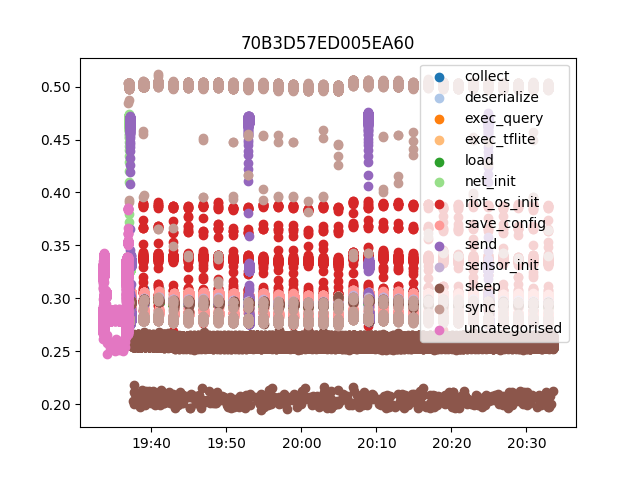

In [33]:
# plot a single nodes consumption where activity indicates colour'
plt.figure()
node_id = power_consumption["node_id"].unique()[1]
to_plot = power_consumption[node_id == power_consumption["node_id"]].groupby("activity", observed=True)
for name, group in to_plot:
    plt.scatter(group["timestamp"], group["power"], label=name)
    plt.title(node_id)
    plt.legend()
plt.show()

In [34]:
# TODO: maybe do some analysis on the riot_os initialisation

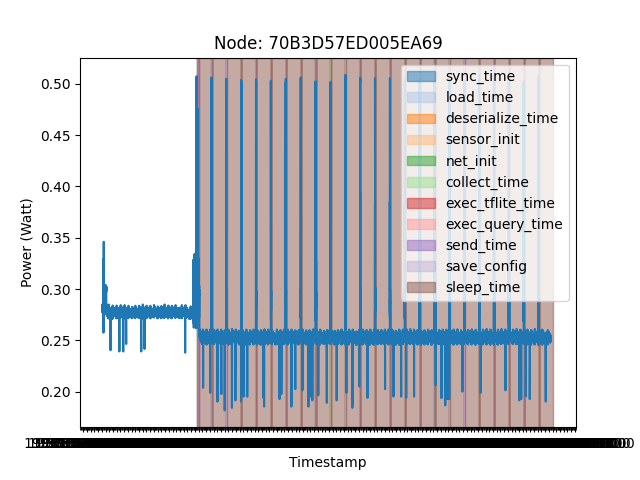

In [35]:
node_id = nodes_with_queries.iloc[-1]["node_id"]
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data["timestamp"], power_data["power"])
alpha = 0.5
for row in timing_data.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, alpha=alpha, label="sync_time", color=plt.cm.tab20(0))
    plt.axvspan(row.load_start, row.load_end, alpha=alpha, label="load_time", color=plt.cm.tab20(1))
    plt.axvspan(row.deserialize_start, row.deserialize_end, alpha=alpha, label="deserialize_time", color=plt.cm.tab20(2))
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, alpha=alpha, label="sensor_init", color=plt.cm.tab20(3))
    plt.axvspan(row.net_init_start, row.net_init_end, alpha=alpha, label="net_init", color=plt.cm.tab20(4))
    plt.axvspan(row.collect_time_start, row.collect_time_end, alpha=alpha, label="collect_time", color=plt.cm.tab20(5))
    plt.axvspan(row.exec_tflite_start, row.exec_tflite_end, alpha=alpha, label="exec_tflite_time", color=plt.cm.tab20(6))
    plt.axvspan(row.exec_query_start, row.exec_query_end, alpha=alpha, label="exec_query_time", color=plt.cm.tab20(7))
    plt.axvspan(row.send_start, row.send_end, alpha=alpha, label="send_time", color=plt.cm.tab20(8))
    plt.axvspan(row.save_config_start, row.save_config_end, alpha=alpha, label="save_config", color=plt.cm.tab20(9))
    plt.axvspan(row.sleep_start, row.sleep_end, alpha=alpha, label="sleep_time", color=plt.cm.tab20(10))
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))
plt.title(f"Node: {node_id}")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [36]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [37]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
#assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
#assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [38]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [39]:
%sql SELECT * from expdb.Content_Message

,content_message_id,frame_counter,frame_port,frame_payload
0,2,-1,1,ChQKEhoQCgQIBBgBEAIYAyIECIDMOg==
1,3,0,2,PDM=
2,5,-1,1,ChQKEhoQCgQIBBgBEAIYAyIECIDMOg==
3,6,0,2,PDM=
4,8,-1,1,ChQKEhoQCgQIBBgBEAIYAyIECIDMOg==
5,9,0,2,PDM=
6,11,-1,1,ChQKEhoQCgQIBBgBEAIYAyIECIDMOg==
7,12,0,2,PDM=
8,14,-1,1,ChQKEhoQCgQIBBgBEAIYAyIECIDMOg==
9,15,0,2,PDM=


In [40]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,iot-lab-saclay-gateway,2024-08-14 19:35:54,2024-08-14 19:35:55.443084,-54,10.25,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-08-14 19:35:55.232214
1,iot-lab-saclay-gateway,2024-08-14 19:37:07,2024-08-14 19:37:08.630476,-30,6.75,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA60,2024-08-14 19:37:08.425551
2,iot-lab-saclay-gateway,2024-08-14 19:38:12,2024-08-14 19:38:12.726798,-41,9.00,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA61,2024-08-14 19:38:12.516706
3,iot-lab-saclay-gateway,2024-08-14 19:39:41,2024-08-14 19:39:41.453825,-28,8.00,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA62,2024-08-14 19:39:41.244085
4,iot-lab-saclay-gateway,2024-08-14 19:40:25,2024-08-14 19:40:25.813660,-30,8.75,125000,867500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA63,2024-08-14 19:40:25.607703
5,iot-lab-saclay-gateway,2024-08-14 19:41:57,2024-08-14 19:41:58.068514,-97,-4.50,125000,868500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA64,2024-08-14 19:41:57.856455
6,iot-lab-saclay-gateway,2024-08-14 19:43:03,2024-08-14 19:43:04.346778,-35,9.00,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA65,2024-08-14 19:43:04.134881
7,iot-lab-saclay-gateway,2024-08-14 19:43:55,2024-08-14 19:43:55.646841,-109,-9.00,125000,868500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA66,2024-08-14 19:43:55.441399
8,iot-lab-saclay-gateway,2024-08-14 19:44:36,2024-08-14 19:44:36.776532,-41,9.00,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA67,2024-08-14 19:44:36.567759
9,iot-lab-saclay-gateway,2024-08-14 19:45:11,2024-08-14 19:45:12.439832,-102,-1.25,125000,868500000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA68,2024-08-14 19:45:12.234413


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [41]:
%%sql
select * from expdb.Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


## calculate avg power per activity

In [42]:
import statsmodels.stats.api as smstats

def calc_confidence_interval(series: pd.Series) -> pd.Series:
    low, high = smstats.DescrStatsW(series).tconfint_mean(alpha=0.05)
    #low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [43]:
power_consumption.groupby(["activity","loop_num"], observed=True)["power"].count()

activity       loop_num
collect        0.0             164
               1.0             181
               2.0             179
               3.0             180
               4.0             180
                            ...   
sync           25.0           5042
               26.0           3583
               27.0           2862
               28.0           1433
uncategorised  0.0         4611790
Name: power, Length: 347, dtype: int64

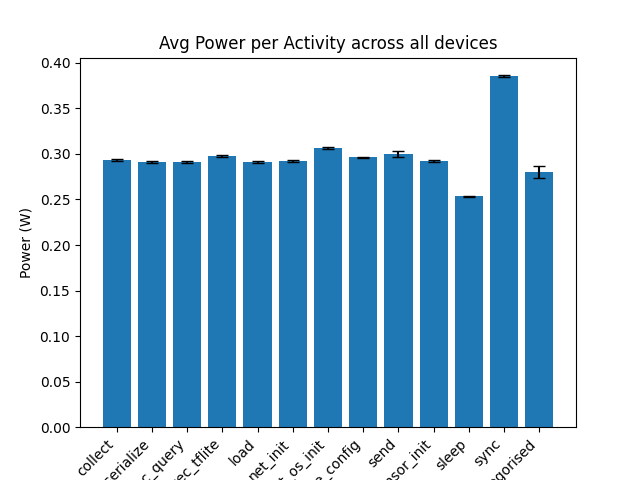

In [44]:

mean_of_loops = power_consumption.groupby(["node_id","activity","loop_num"], observed=True)["power"].mean()
mean_of_activities_of_loops = mean_of_loops.groupby(["activity"], observed=True).mean()
errors = mean_of_loops.groupby(["activity"], observed=True).apply(calc_confidence_interval).unstack(level=-1)
errors_relative = np.abs(errors.T - mean_of_activities_of_loops)
## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
# print((mean_of_activities_of_loops.repeat(2)).values)
#error_relative = np.abs(errors - mean_of_activities_of_loops)
plt.figure()
plt.bar(mean_of_activities_of_loops.index, mean_of_activities_of_loops.values, yerr=errors_relative.values, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Activity")
plt.ylabel("Power (W)")
plt.title("Avg Power per Activity across all devices")
plt.show()

## remove baseline power consumption from measurements
We assume sleep gives us a good baseline for low power consumption so to make clearer the differences between periods we subtract sleep

In [45]:
sleep_baseline = power_consumption[power_consumption["activity"] == "sleep"]["power"].mean()
# this takes the average of all sleep measurement which is different than the average worked with so far,
# which is the average per activity per loop averaged for all loops
sleep_baseline

0.2533179

In [46]:
## check how the data now looks. we ignore the sleep and uncategorised
power_consumption["power_without_sleep"] = power_consumption["power"] - sleep_baseline
power_consumption[(power_consumption["activity"] != "sleep") & (power_consumption["activity"] != "uncategorised")]["power_without_sleep"].describe()

count    1.016401e+06
mean     7.266168e-02
std      7.527792e-02
min     -7.505989e-02
25%      2.688810e-02
50%      4.398212e-02
75%      7.023209e-02
max      3.144201e-01
Name: power_without_sleep, dtype: float64

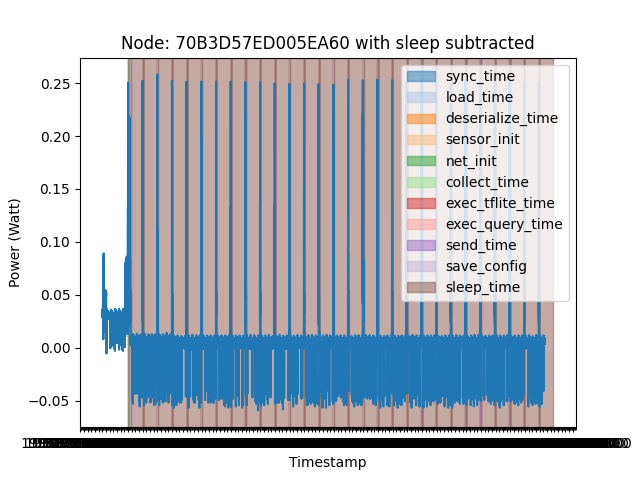

In [47]:
## plot a node with the new data with activities
node_id = nodes_with_queries.iloc[0]["node_id"]
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data["timestamp"], power_data["power_without_sleep"])
for row in timing_data.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, alpha=alpha, label="sync_time", color=plt.cm.tab20(0))
    plt.axvspan(row.load_start, row.load_end, alpha=alpha, label="load_time", color=plt.cm.tab20(1))
    plt.axvspan(row.deserialize_start, row.deserialize_end, alpha=alpha, label="deserialize_time", color=plt.cm.tab20(2))
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, alpha=alpha, label="sensor_init", color=plt.cm.tab20(3))
    plt.axvspan(row.net_init_start, row.net_init_end, alpha=alpha, label="net_init", color=plt.cm.tab20(4))
    plt.axvspan(row.collect_time_start, row.collect_time_end, alpha=alpha, label="collect_time", color=plt.cm.tab20(5))
    plt.axvspan(row.exec_tflite_start, row.exec_tflite_end, alpha=alpha, label="exec_tflite_time", color=plt.cm.tab20(6))
    plt.axvspan(row.exec_query_start, row.exec_query_end, alpha=alpha, label="exec_query_time", color=plt.cm.tab20(7))
    plt.axvspan(row.send_start, row.send_end, alpha=alpha, label="send_time", color=plt.cm.tab20(8))
    plt.axvspan(row.save_config_start, row.save_config_end, alpha=alpha, label="save_config", color=plt.cm.tab20(9))
    plt.axvspan(row.sleep_start, row.sleep_end, alpha=alpha, label="sleep_time", color=plt.cm.tab20(10))
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))
plt.title(f"Node: {node_id} with sleep subtracted")
plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()

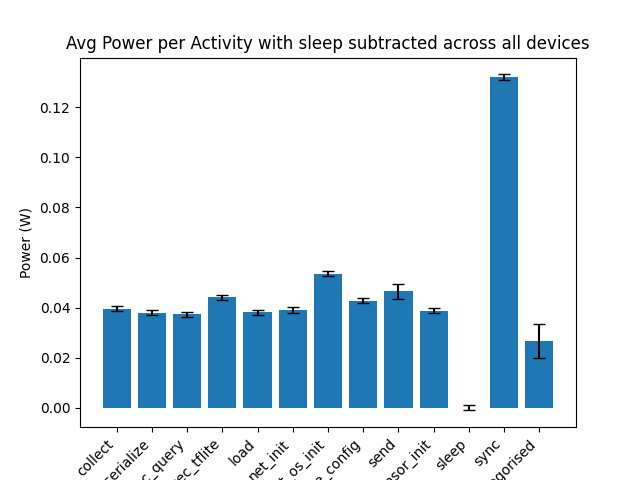

In [48]:
mean_of_loops_without_sleep = power_consumption.groupby(["node_id","activity","loop_num"], observed=True)["power_without_sleep"].mean()
mean_of_activities_of_loops_without_sleep = mean_of_loops_without_sleep.groupby(["activity"], observed=True).mean()
errors = mean_of_loops_without_sleep.groupby(["activity"], observed=True).apply(calc_confidence_interval).unstack(level=-1)
errors_relative = np.abs(errors.T - mean_of_activities_of_loops_without_sleep)
## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
# print((mean_of_activities_of_loops.repeat(2)).values)
#error_relative = np.abs(errors - mean_of_activities_of_loops)
plt.figure()
plt.bar(mean_of_activities_of_loops_without_sleep.index, mean_of_activities_of_loops_without_sleep.values, yerr=errors_relative.values, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Activity")
plt.ylabel("Power (W)")
plt.title("Avg Power per Activity with sleep subtracted across all devices")
plt.show()

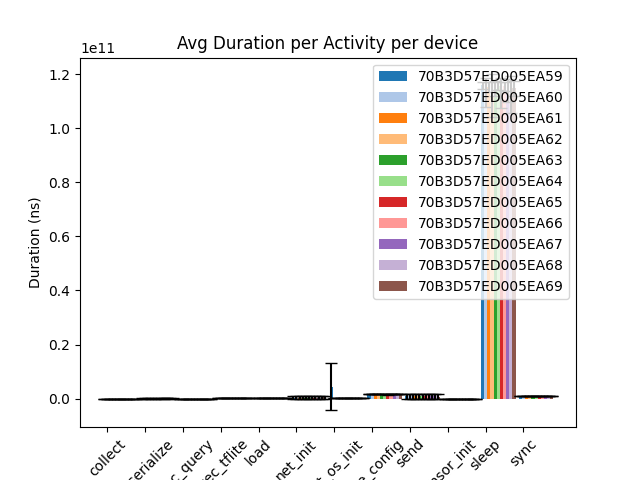

In [49]:
## lets look at time consumption per activity
grouped_timestamps = power_consumption[(power_consumption["activity"] != "uncategorised") & (power_consumption["node_id"].isin(nodes_with_queries["node_id"]))].groupby(["node_id","activity","loop_num"], observed=True)["timestamp"]
duration_of_activity_per_nodeid_activity_loopnum = grouped_timestamps.max() - grouped_timestamps.min()
duration_of_activity_per_nodeid_activity_loopnum.rename("duration", inplace=True)

#and then take mean of loops for each node_id,activity. and also calculate CI
grouped = duration_of_activity_per_nodeid_activity_loopnum.groupby(["node_id","activity"], observed=True)
mean_duration_of_activity_per_nodeid_activity = grouped.mean()

mean_duration_of_activity_per_nodeid_activity_ci = pd.to_timedelta(grouped.apply(lambda x: calc_confidence_interval(pd.to_numeric(x))), unit="us").unstack(-1)


errors_relative = mean_duration_of_activity_per_nodeid_activity_ci.sub(mean_duration_of_activity_per_nodeid_activity, axis=0).abs()


# since matplotlib and pandas are annoying we have to construct the plot to get the error bars
x_labels = mean_duration_of_activity_per_nodeid_activity.index.get_level_values(1).unique()
locations = np.arange(len(x_labels))
width = 1 / len(x_labels)
multiplier = 0

grouped = mean_duration_of_activity_per_nodeid_activity.groupby("node_id", observed=True)

plt.figure()
for node_id, group in grouped:
    group = group.astype("timedelta64[ns]").values
    yerrs = errors_relative.loc[idx[node_id,:]].T.values
    offset = width * multiplier
    plt.bar(locations+offset, group, width=width, label=node_id, yerr=errors_relative.loc[idx[node_id,:]].T.values, log=False, capsize=4)
    multiplier += 1

plt.xticks(ticks=locations+width, labels=x_labels, rotation=45)
plt.xlabel("Activity")
plt.ylabel("Duration (ns)")
plt.title("Avg Duration per Activity per device")
plt.legend()
plt.show()


In [50]:
## now that we can see they are extremely similar, lets take an average across all devices
duration_results = duration_of_activity_per_nodeid_activity_loopnum.groupby(["activity"], observed=True).mean().copy()
#convert the timings to raw ms
# add _duration suffix to categorical index
duration_results.index = duration_results.index.rename_categories([f"{cat}_duration_us" for cat in duration_results.index.categories])
duration_results = duration_results.apply(lambda x: int(x / pd.Timedelta("1us")))


energy_results = mean_of_activities_of_loops_without_sleep.copy()
energy_results.index = energy_results.index.rename_categories([f"{cat}_watts" for cat in energy_results.index.categories])
current_results = pd.DataFrame(pd.concat([duration_results, energy_results])).T
current_results.columns.name = None
current_results["experiment_id"] = int(EXP_ID)

#read the existing csv file "results" and combine with current results

import os
if os.path.exists("results.csv"):
    results = pd.read_csv("results.csv",header=0)
    results = pd.concat([results,current_results], join="inner", axis=0)
    results = results.drop_duplicates(subset="experiment_id")
    results = results.set_index("experiment_id")
    results = results.sort_index()
    results.to_csv("results.csv")
    
else:
    current_results.to_csv("results.csv")


## initial model thoughts
The Energy consumed is roughly the average power in activity times length of activity. All energy consumed during activities are affected by outside factors as either their power or length is affected. However most are amortized constant. Here is an overview:

- **Riot OS initialization**: constant

    Riot needs to boot. This takes some time and power.

- **sync**: constant

    Only applicable for testing, so removed in real-world scenario
    

- **load**: dependent on query length

    Loads network configuration (constant time) and serialized query (dependent on query length)


- **deserialize**: dependent on query length

    If there is a query, deserialize it. This should probably be classified under load, even though it technically happens in different places in Terra


- **sensor_init**: Mostly constant. depend on sensors

    initialises sensors and their communication channels. Some sensors require no initialization, while others have boot-up times, calibration or others that require varying amounts of power and time.  


- **net_init**: amortized constant.

    Initialises network. If not connected, this requires a power and time costly OTAA procedure that is highly dependent on environment. If already connected, this is a constant time OS initialization.

- **sensor_collect**: Mostly constant. depend on sensors

    Collection of sensor values. some sensors is a simple constant time read. Others need to perform activities like running a fan until some threshold is passed. 


- **exec**: dependent on query length and tflite complexity

    - tflite might have a fixed constant cost or be more flexible. More testing needed
    - query length might have a fixed constant cost or be more flexible. More testing needed



- **send**: dependent on query, filter selectivity and guaranteed send parameter

    send is highly dependent on number of results to transmit and if a query passes a filter or not. and on environment.


- **save_config**: dependent on query length

    Could possibly also go under a new variable called "ConfigHandling" or the like


- **sleep**: dependent on all others

    However we assume this is the lowest possible power state so nothing can be done about this


each of the above points can be a parameter in the energy model, and their absolute power cost will be either a constant or a factor times the baseline power consumption. The values for these have to be derived experimentally and are unique per device model

Given the info above we produce the formula below

$$
\text{Epoch}_{Energy} = \text{LoadConfig}_{time}\cdot\text{LoadConfig}_{power} + \text{Deserialize}_{time}\cdot\text{Deserialize}_{power} +  \text{SensorInit}_{time}\cdot\text{SensorInit}_{power}+ \text{NetInit}_{time}\cdot\text{NetInit}_{power} + \text{SensorCollect}_{time}\cdot\text{SensorCollect}_{power}+ \text{Exec}_{time}\cdot\text{Exec}_{power} + \text{Send}_{time}\cdot\text{Send}_{power}+ \text{SaveConfig}_{time}\cdot\text{SaveConfig}_{power}
$$

## Calculate Total Energy Consumed per activity

In [51]:
#define function to calculate energy consumed
def calc_energy_consumed(df: pd.DataFrame):
    """
    calculate energy consumed in the given dataframe. Assumes the times are in index and is of type pd.DatetimeIndex and power is in column "power"
    Assumes power is in W
    :param df: dataframe with power consumption
    :return: energy consumed in the unit of W times s or J
    """
    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    #     # ensure we only calculate for data frames containing data from a single node
    # assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # # assert df have columns "power" and index of "timestamp" type
    # assert "power" in df.columns, "power column not found"
    # assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.values
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [52]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    power_consumption_for_node.set_index("timestamp", inplace=True)
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops["start_time"]:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["start_time"]:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "deserialize": calc_energy_consumed(power_consumption_for_node.loc[series_loops["deserialize_start"]:series_loops["deserialize_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "tflite execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_tflite_start"]:series_loops["exec_tflite_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_query_start"]:series_loops["exec_query_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,deserialize,sensor init,net init,sensor collect,tflite execution,query execution,send,save config,sleep
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,12.825342,30.186382,0.309421,29.876645,0.040420,0.007317,0.004013,0.118294,0.005049,0.008865,0.002853,0.282314,0.453550,28.949840
std,7.761942,2.844191,0.008138,2.841351,0.001250,0.001363,0.000295,0.513592,0.000259,0.000326,0.000639,0.733549,0.016921,2.978295
min,0.000000,3.268126,0.283208,2.961404,0.036305,0.000318,0.003213,0.015083,0.004133,0.007994,0.000000,0.000000,0.399729,2.420380
25%,6.000000,30.492907,0.308268,30.178947,0.040315,0.007463,0.003925,0.016866,0.004919,0.008717,0.002844,0.000335,0.450509,29.553665
50%,13.000000,30.616757,0.311128,30.305298,0.040642,0.007589,0.004027,0.016983,0.005045,0.008925,0.002983,0.000647,0.454169,29.723791
75%,19.000000,31.094463,0.313184,30.781681,0.041122,0.007690,0.004272,0.017146,0.005248,0.009111,0.003240,0.000666,0.459166,30.055970
max,28.000000,32.361913,0.322011,32.046914,0.041924,0.008060,0.004410,2.777617,0.005687,0.009396,0.003372,3.228375,0.517591,30.455389


In [53]:
energy_consumed.head()

,node_id,loop_num,total,loop signal,total without loop signal,load config,deserialize,sensor init,net init,sensor collect,tflite execution,query execution,send,save config,sleep
loop_signal_start,,,,,,,,,,,,,,,
2024-08-14 19:36:57.686098,70B3D57ED005EA60,0,32.299989,0.312945,31.986728,0.041469,0.000332,0.004344,2.745584,0.004642,0.008838,0.000000,3.209828,0.511444,25.456573
2024-08-14 19:38:57.132367,70B3D57ED005EA60,1,31.242540,0.313965,30.928258,0.041330,0.007714,0.004381,0.017096,0.005062,0.009273,0.003016,0.000666,0.448274,30.387087
2024-08-14 19:40:56.844749,70B3D57ED005EA60,2,31.248098,0.314503,30.933278,0.041433,0.007730,0.004403,0.017152,0.005071,0.008957,0.003352,0.000672,0.461934,30.378190
2024-08-14 19:42:56.598203,70B3D57ED005EA60,3,31.083917,0.313167,30.770424,0.041168,0.007689,0.004372,0.017028,0.005045,0.008892,0.003327,0.000667,0.459081,30.218794
2024-08-14 19:44:56.350924,70B3D57ED005EA60,4,31.090092,0.313401,30.776369,0.041276,0.007699,0.004054,0.017411,0.005052,0.008922,0.003341,0.000666,0.460377,30.223212


In [54]:
# define the columns we want to work with. Note that since we dont include node_id we effectively remove the individual nodes from the calculations
columns_without_totals = ["loop signal", "load config", "deserialize", "sensor init", "net init", "sensor collect","tflite execution", "query execution", "send", "save config", "sleep"]
columns = ["total", "total without loop signal"] + columns_without_totals

In [55]:
error_bounds = energy_consumed[columns].apply(calc_confidence_interval)
error_bounds

,total,total without loop signal,loop signal,load config,deserialize,sensor init,net init,sensor collect,tflite execution,query execution,send,save config,sleep
low,29.858796,29.549386,0.308483,0.040276,0.007160,0.003979,0.059140,0.005019,0.008828,0.002780,0.197826,0.451602,28.606808
high,30.513968,30.203904,0.310358,0.040564,0.007474,0.004047,0.177448,0.005079,0.008903,0.002927,0.366802,0.455499,29.292871


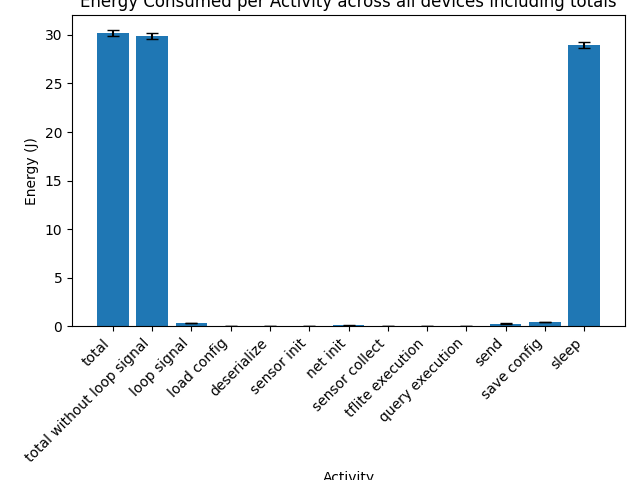

In [56]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[columns]

## since error_bounds are absolute and matplotlib likes them relative, we need to substract the mean to get relative error - and take the absolute to flip
## the sign on the lower bound
error_relative = np.abs(error_bounds - to_plot.loc["mean"])

plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

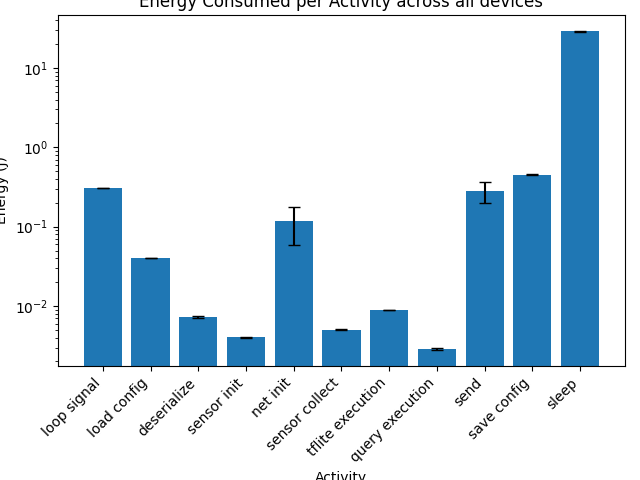

In [57]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[columns_without_totals]
error_relative = np.abs(error_bounds[columns_without_totals] - to_plot.loc["mean"])
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=error_relative, log=True, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [58]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [59]:
error_bounds_without_0th_loop = without_0th_loop[columns].apply(calc_confidence_interval)


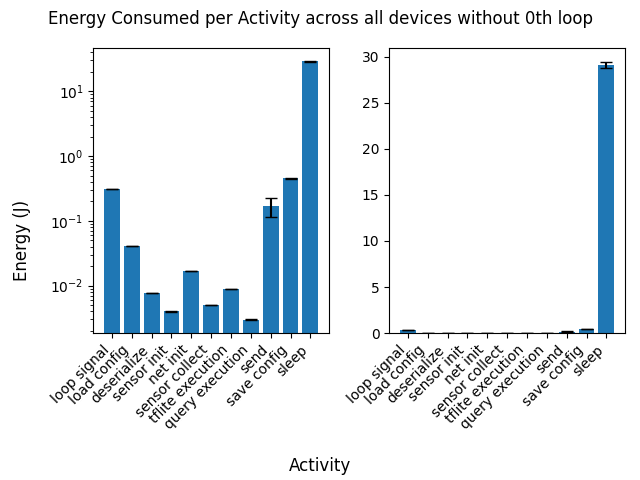

In [60]:
to_plot = without_0th_loop_summary[columns_without_totals]

errors_relative = np.abs(error_bounds_without_0th_loop[columns_without_totals] - to_plot.loc["mean"])
#energy_consumed_without_0th_loop
## plot both with log scale and without
fig, (ax1, ax2) =  plt.subplots(1,2)

fig.suptitle("Energy Consumed per Activity across all devices without 0th loop")
fig.supxlabel("Activity")
fig.supylabel("Energy (J)")

ax1.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4, log=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
ax2.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors_relative, capsize=4)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")



plt.tight_layout()
plt.show()

In [61]:
without_0th_loop.groupby("node_id").describe()

loop_num                                               total  \
                    count  mean       std  min   25%   50%    75%   max count   
node_id                                                                         
70B3D57ED005EA59     28.0  14.5  8.225975  1.0  7.75  14.5  21.25  28.0  28.0   
70B3D57ED005EA60     28.0  14.5  8.225975  1.0  7.75  14.5  21.25  28.0  28.0   
70B3D57ED005EA61     27.0  14.0  7.937254  1.0  7.50  14.0  20.50  27.0  27.0   
70B3D57ED005EA62     27.0  14.0  7.937254  1.0  7.50  14.0  20.50  27.0  27.0   
70B3D57ED005EA63     26.0  13.5  7.648529  1.0  7.25  13.5  19.75  26.0  26.0   
70B3D57ED005EA64     25.0  13.0  7.359801  1.0  7.00  13.0  19.00  25.0  25.0   
70B3D57ED005EA65     25.0  13.0  7.359801  1.0  7.00  13.0  19.00  25.0  25.0   
70B3D57ED005EA66     24.0  12.5  7.071068  1.0  6.75  12.5  18.25  24.0  24.0   
70B3D57ED005EA67     24.0  12.5  7.071068  1.0  6.75  12.5  18.25  24.0  24.0   
70B3D57ED005EA68     24.0  12.5  7.071068  1.0  6.75  12.5  18.25  24.0  24.0   
70B3D57ED005EA69     23.0  12.0  6.782330  1.0  6.50  12.0  17.50  23.0  23.0   

                             ... save config           sleep             \
                       mean  ...         75%       max count       mean   
node_id                      ...                                          
70B3D57ED005EA59  31.316672  ...    0.469113  0.471219  28.0  30.278453   
70B3D57ED005EA60  30.463437  ...    0.460359  0.463498  28.0  29.437232   
70B3D57ED005EA61  30.452809  ...    0.452293  0.454227  27.0  29.434797   
70B3D57ED005EA62  29.620060  ...    0.452875  0.453782  27.0  28.606164   
70B3D57ED005EA63  30.367363  ...    0.455625  0.458548  26.0  29.335948   
70B3D57ED005EA64  30.915004  ...    0.460856  0.465183  25.0  29.870476   
70B3D57ED005EA65  30.627604  ...    0.458333  0.462170  25.0  29.576776   
70B3D57ED005EA66  30.590360  ...    0.457027  0.460539  24.0  29.550776   
70B3D57ED005EA67  26.922533  ...    0.411788  0.414795  24.0  25.973003   
70B3D57ED005EA68  29.652122  ...    0.453646  0.455940  24.0  28.616409   
70B3D57ED005EA69  30.242925  ...    0.458204  0.461864  23.0  29.256173   

                                                                        \
                       std        min        25%        50%        75%   
node_id                                                                  
70B3D57ED005EA59  0.330773  29.360165  30.397514  30.401636  30.406464   
70B3D57ED005EA60  3.620331  11.041296  30.217286  30.218596  30.221850   
70B3D57ED005EA61  0.946534  24.986389  29.720957  29.722178  29.724818   
70B3D57ED005EA62  5.243383   2.420380  29.727656  29.730227  29.732438   
70B3D57ED005EA63  1.607365  21.622258  29.759952  29.764469  29.768449   
70B3D57ED005EA64  0.400990  28.842632  30.021349  30.040179  30.051935   
70B3D57ED005EA65  3.650386  12.133603  30.421456  30.429554  30.440429   
70B3D57ED005EA66  0.426988  28.058918  29.690847  29.700835  29.709913   
70B3D57ED005EA67  2.186001  15.782722  26.482978  26.494779  26.501847   
70B3D57ED005EA68  4.282670   8.554060  29.558441  29.572747  29.584828   
70B3D57ED005EA69  1.342413  23.242495  29.612863  29.619520  29.624433   

                             
                        max  
node_id                      
70B3D57ED005EA59  30.413500  
70B3D57ED005EA60  30.387087  
70B3D57ED005EA61  29.729255  
70B3D57ED005EA62  29.737250  
70B3D57ED005EA63  29.783206  
70B3D57ED005EA64  30.066268  
70B3D57ED005EA65  30.455389  
70B3D57ED005EA66  29.733594  
70B3D57ED005EA67  26.520708  
70B3D57ED005EA68  29.617496  
70B3D57ED005EA69  29.641795  

[11 rows x 112 columns]

In [62]:
## plot per node
grouped = without_0th_loop[['node_id'] + columns_without_totals] \
    .groupby("node_id")
# grouped_agg = grouped.agg(["mean", "std"])
# def hej(row: pd.Series):
#     outermost_column = list(set(k[0] for k in row.keys()))
#     idx = pd.MultiIndex.from_product([outermost_column, ["low","high"]])
#     res = pd.Series(index=idx)
#     for col in outermost_column:
#         res[col] = calc_confidence_interval(row[col])
#     return res
# ci = grouped_agg.apply(hej, axis=1)

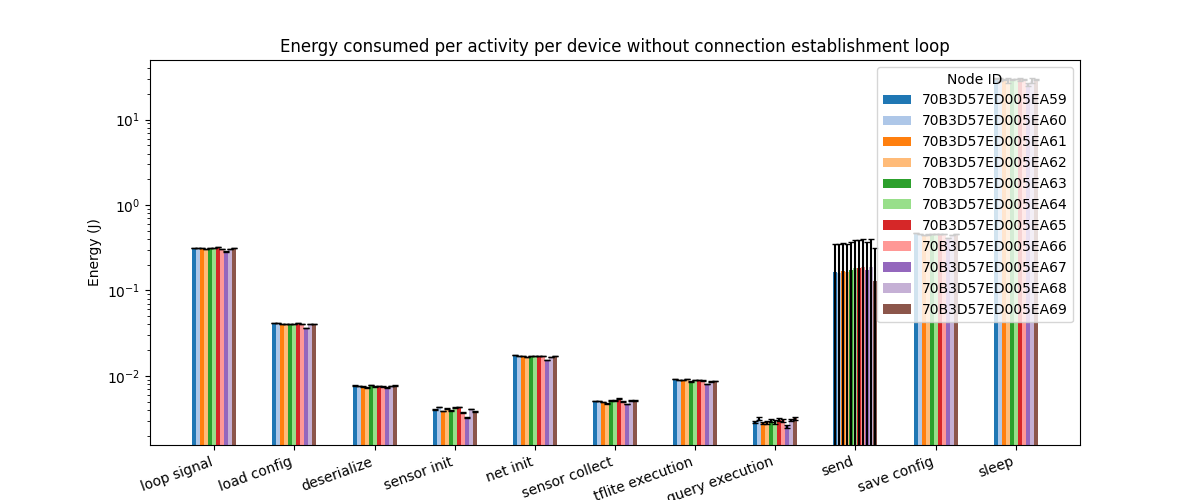

In [63]:
locations = np.arange(len(columns_without_totals))
width = 0.05
multiplier = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for node_id, row in grouped:
    values = row[columns_without_totals].mean().values
    error_bounds = row[columns_without_totals].apply(calc_confidence_interval)
    errors_relative = np.abs(error_bounds - values)
    #values = row.loc[node_id,(slice(None),"mean")][columns].values
    #errors_low = values - ci.loc[node_id,(slice(None),"low")][columns]
    #errors_high = ci.loc[node_id,(slice(None),"high")][columns] - values
    # for node_id, mean in row.loc[activity,"mean"].items():
    offset = width * multiplier

    rects = ax.bar(locations + offset, values, width, capsize=2, label=node_id, yerr=errors_relative, log=True)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(title="Node ID")
ax.set_title("Energy consumed per activity per device without connection establishment loop")
ax.set_ylabel("Energy (J)")
ax.set_xlabel("Activity")
ax.set_xticks(locations + 0.25, columns_without_totals, rotation=20, ha="right")
plt.show()

In [64]:

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse

# TODO: from Viktor
# before doing the above try to from the data you have derive a power consumption per time period and estimate the powerconsumption linearly based on the time the activity takes
